Functions Used:
1.   **LoadImages**: is used to load all the images inside the folders and them to vectors. It returns the matrix containing the vector of each images of the folderconvert 

***Note:* We need to run the program and give the value of K (atmost 20) to learn the model**

In [62]:
%matplotlib inline



In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
%cd /content/drive/MyDrive/MLSP/Assignments/Assignment 1/Data/emotion_classification

/content/drive/MyDrive/MLSP/Assignments/Assignment 1/Data/emotion_classification


In [65]:
import os
from PIL import Image
import math
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
def LoadImages(directory):
    Data_Samples=np.array([])
    label=[]
    flag=0
    for fname in os.scandir(directory):
        if fname.is_file():
            if str(fname).count("gif") == 0:
                continue
            fname = str(fname.path).split("/")[-1]
            img = asarray(Image.open(directory + "/" + fname), dtype=float)
            img = np.reshape(img, (1, img.shape[0]*img.shape[0]))
            label.append(fname.split(".")[1])
            if flag==0:
                Data_Samples = np.array(img, copy=True)
                flag=1
            else:
                Data_Samples = np.vstack((Data_Samples, img))
    return Data_Samples,label
directory = '/content/drive/MyDrive/MLSP/Assignments/Assignment 1/Data/emotion_classification/train'

#Loading the training images and finding N= no of samples, D=dimension of the samples
Original_Data_Samples,labels=LoadImages(directory)
N=Original_Data_Samples.shape[0]
D=Original_Data_Samples.shape[1]

mean=np.mean(Original_Data_Samples,axis=0)

Original_Data_Samples=Original_Data_Samples-mean
dataSampleTranspose=Original_Data_Samples.T

In [66]:
#Here the projection matrix for the PCA is calculated
Data_Cov= (Original_Data_Samples @ dataSampleTranspose)/N
eigenValues,eigenVectores = np.linalg.eigh(Data_Cov)
eigenDictionary = {eigenValues[i]: eigenVectores[i] for i in range(len(eigenValues))}

eigenValues=sorted(eigenValues,reverse=True)

Proj_Matrix=np.array([])
KDIM=int(input("Enter the no of reduced dimension i.e K value:"))
for i in range(0,KDIM):
    if i==0:
        eigen = np.reshape(eigenDictionary[eigenValues[0]], (20, 1))
        eigenvector = (dataSampleTranspose  @ eigen) / math.sqrt((eigenValues[0] * N))
        Proj_Matrix = np.array(eigenvector, copy=True)
    else:
        eigen = np.reshape(eigenDictionary[eigenValues[i]], (20, 1))
        eigenvector=(dataSampleTranspose  @ eigen)  / math.sqrt((eigenValues[i] * N))
        Proj_Matrix = np.vstack((Proj_Matrix,eigenvector))



Enter the no of reduced dimension i.e K value:18


In [67]:
#Here the training data is projected onto the PCA projection matrix calculated above
PCA_Transformed_Data=np.array([])
Proj_Matrix=np.reshape(Proj_Matrix,(KDIM,D))
for i in range(0, len(Original_Data_Samples)):
    if i==0:
        data = np.reshape(Original_Data_Samples[i], (1, D))
        PCA_Transformed_Data=np.array(Proj_Matrix @ data.T, copy=True)
    else:
        data = np.reshape(Original_Data_Samples[i], (1, D))
        PCA_Transformed_Data = np.vstack((PCA_Transformed_Data,Proj_Matrix @ data.T))
PCA_Transformed_Data=np.reshape(PCA_Transformed_Data,(20,KDIM))

In [68]:
#Finding the covariance of each class of the training data
m1,m2 = np.empty((1,KDIM), dtype=float), np.empty((1,KDIM), dtype=float)
Sad_N,Happy_N=0,0
for i in range(0,N):
    if labels[i]=="sad":
        A=np.reshape(PCA_Transformed_Data[i],(1,PCA_Transformed_Data[i].shape[0]))
        m1 = m1+ A
        Sad_N+=1
    elif labels[i]=="happy":
        A=np.reshape(PCA_Transformed_Data[i],(1,PCA_Transformed_Data[i].shape[0]))
        m2 = m2+ A
        Happy_N+=1
m1,m2 =m1/Sad_N,m2/Happy_N
S_w_Sad,S_w_Happy = np.array([]),np.array([])
for i in range(0,N):
    flag = not np.any(S_w_Happy)
    if labels[i]=="happy":
        if flag:
            A = np.reshape(PCA_Transformed_Data[i], (1, PCA_Transformed_Data[i].shape[0]))
            S_w_Happy = np.dot((A - m2).transpose(), A - m2)
        else:
            A = np.reshape(PCA_Transformed_Data[i], (1, PCA_Transformed_Data[i].shape[0]))
            S_w_Happy = np.add(S_w_Happy, np.dot((A - m2).transpose(), A - m2))
    flag = not np.any(S_w_Sad)
    if labels[i]=="sad":
        if flag:
            A = np.reshape(PCA_Transformed_Data[i], (1, PCA_Transformed_Data[i].shape[0]))
            S_w_Sad = np.dot((A - m1).transpose(),A - m1)
        else:
            A = np.reshape(PCA_Transformed_Data[i], (1, PCA_Transformed_Data[i].shape[0]))
            S_w_Sad = np.add(S_w_Sad, np.dot((A - m1).transpose(),A - m1 ))


In [69]:
#Finding the within class covariance matrix
S_w=S_w_Sad+S_w_Happy

#Calculating the LDA projection matrix
w=np.dot(np.linalg.inv(S_w),(m2-m1).transpose())
w/=np.linalg.norm(w)

In [70]:
#Projecting the PCA projected data onto the LDA projection matrix calculated above
data = np.reshape(PCA_Transformed_Data[0], (1, PCA_Transformed_Data[0].shape[0]))
LDA_Transformed_Data=np.array(w.transpose() @ data.transpose(), copy=True)
for i in range(1,len(PCA_Transformed_Data)):
    data = np.reshape(PCA_Transformed_Data[i], (1, PCA_Transformed_Data[i].shape[0]))
    LDA_Transformed_Data = np.vstack((LDA_Transformed_Data,w.transpose() @ data.transpose()))

In [71]:
#Calculating the means of each LDA projected classes
final_Threshold1=0;
final_Threshold2=0;
sad_training=[]
happy_training=[]

for i in range(0,len(LDA_Transformed_Data)):
    if labels[i]=="sad":
        sad_training.append(LDA_Transformed_Data[i])
        final_Threshold1+= LDA_Transformed_Data[i]
    elif labels[i]=="happy":
        happy_training.append(LDA_Transformed_Data[i])
        final_Threshold2+= LDA_Transformed_Data[i]
final_Threshold1=final_Threshold1/Sad_N
final_Threshold2=final_Threshold2/Happy_N

In [72]:
#Loading the test data samples
Test_Data=np.array([])
Test_Labels=[]
directory = '/content/drive/MyDrive/MLSP/Assignments/Assignment 1/Data/emotion_classification/test'
Test_Data,Test_Labels=LoadImages(directory)

In [73]:
#Projecting the test data onto the PCA projection matrix calculated above
data = np.reshape(Test_Data[0], (1, D))
PCA_Test_Data=np.array(Proj_Matrix @ data.T, copy=True)
for i in range(1,len(Test_Data)):
    data = np.reshape(Test_Data[i], (1, D))
    PCA_Test_Data = np.vstack((PCA_Test_Data,Proj_Matrix @ data.T))
PCA_Test_Data=np.reshape(PCA_Test_Data,(10,KDIM))

In [74]:
#Projecting the PCA projected test data onto the LDA projection matrix calculated above
data = np.reshape(PCA_Test_Data[0], (1, PCA_Test_Data[0].shape[0]))
LDA_Transformed_Test_Data=np.dot(w.transpose(), data.transpose())
for i in range(1,len(PCA_Test_Data)):
    data = np.reshape(PCA_Test_Data[i], (1, PCA_Test_Data[i].shape[0]))
    LDA_Transformed_Test_Data = np.vstack((LDA_Transformed_Test_Data,(w.transpose()@ data.transpose())))

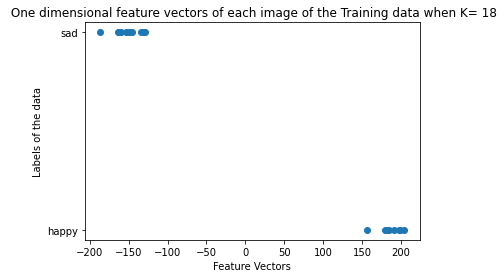

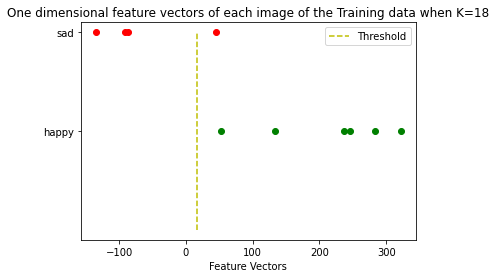

Accuracy rate of the model when k= 18 : 90.0 %
Separation between Happy and Sad classes when k= 18 : 285.52259879287607


In [75]:
#Predicting the labels of each sample of the test data by a predicting rule
passed=0
Sad_Prediction=[]
Happy_Prediction=[]
final_Threshold=(final_Threshold1+final_Threshold2)/2

for i in range(0,len(LDA_Transformed_Test_Data)):
    if final_Threshold<=float(LDA_Transformed_Test_Data[i]):
        if Test_Labels[i]=="happy":
            Happy_Prediction.append(LDA_Transformed_Test_Data[i])
            passed+=1
        else:
            Sad_Prediction.append(LDA_Transformed_Test_Data[i])

    else:
        if Test_Labels[i]=="sad":
            Sad_Prediction.append(LDA_Transformed_Test_Data[i])
            passed+=1
        else:
            Happy_Prediction.append(LDA_Transformed_Test_Data[i])

plt.scatter(list( LDA_Transformed_Data),labels)
plt.title(" One dimensional feature vectors of each image of the Training data when K= {0}".format(KDIM))

plt.xlabel("Feature Vectors")
plt.ylabel("Labels of the data")
plt.show()


plt.scatter(x=list(Happy_Prediction),y=["happy"]*len(list(Happy_Prediction)),color="green")
plt.scatter(x=list(Sad_Prediction),y=["sad"]*len(list(Sad_Prediction)), color="red")
plt.title("One dimensional feature vectors of each image of the Training data when K={0}".format(KDIM))
plt.vlines(final_Threshold, -1, 1, colors='y', linestyles='--', label='Threshold')
plt.xlabel("Feature Vectors")
plt.legend()
plt.show()


print("Accuracy rate of the model when k= {0} : {1} %".format(KDIM,(passed/len(Test_Labels))*100))
print("Separation between Happy and Sad classes when k= {0} : {1}".format(KDIM,float(((min(happy_training)-max(sad_training))))))
